# Parnian Taheri
## Deep Learning
### Homework 3 - Q2

In [1]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, Dataset
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_indices = [i for i, label in enumerate(train_dataset.targets) if label in [0, 1]]
test_indices = [i for i, label in enumerate(test_dataset.targets) if label in [0, 1]]

train_data = torch.utils.data.Subset(train_dataset, train_indices)
test_data = torch.utils.data.Subset(test_dataset, test_indices)

100%|██████████| 170M/170M [00:05<00:00, 30.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Part A - Cross Entropy Loss

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.2732, Accuracy: 88.16%


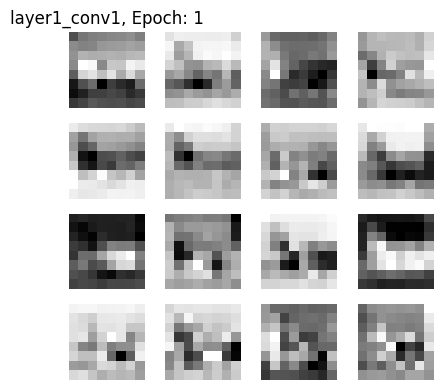

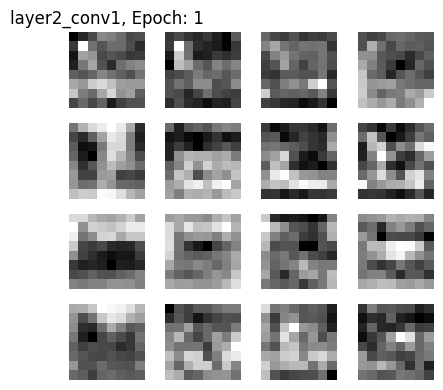

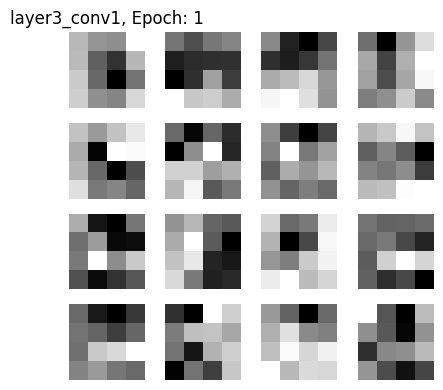

Epoch 2, Loss: 0.0745, Accuracy: 97.20%


Epoch 3, Loss: 0.0302, Accuracy: 99.10%


Epoch 4, Loss: 0.0168, Accuracy: 99.56%


Epoch 5, Loss: 0.0152, Accuracy: 99.62%


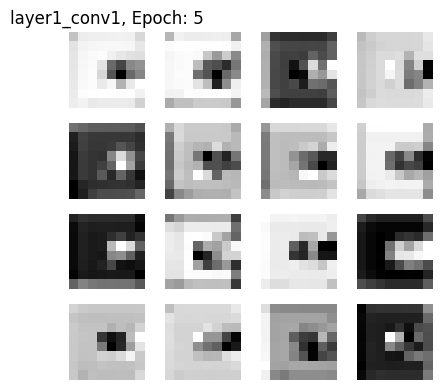

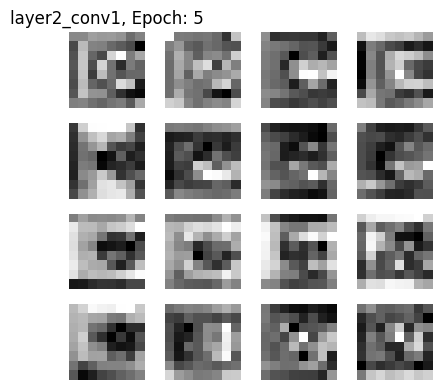

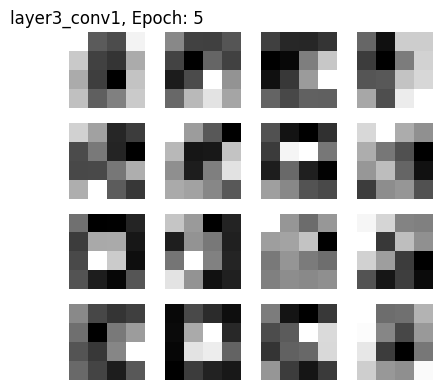

Epoch 6, Loss: 0.0074, Accuracy: 99.77%


Epoch 7, Loss: 0.0059, Accuracy: 99.85%


Epoch 8, Loss: 0.0060, Accuracy: 99.89%


Epoch 9, Loss: 0.0049, Accuracy: 99.90%


Epoch 10, Loss: 0.0037, Accuracy: 99.90%


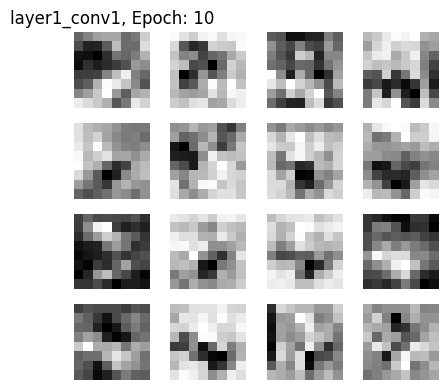

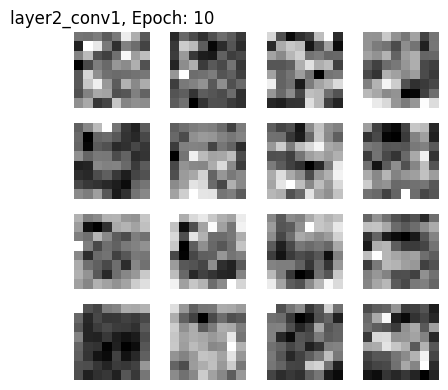

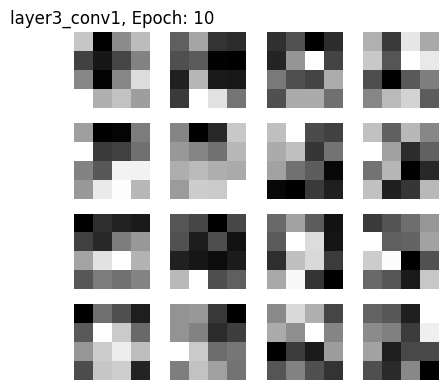

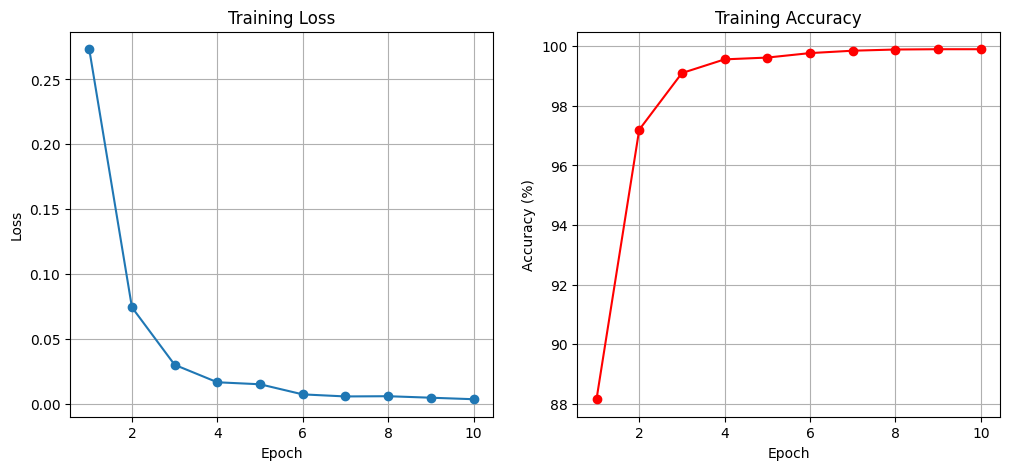

In [21]:
model = models.resnet50(pretrained=True).to(device)
model.fc = nn.Linear(model.fc.in_features, 2).to(device)

# Registering hooks to capture feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.layer1[0].conv1.register_forward_hook(get_activation('layer1_conv1'))
model.layer2[0].conv1.register_forward_hook(get_activation('layer2_conv1'))
model.layer3[0].conv1.register_forward_hook(get_activation('layer3_conv1'))

def train_and_visualize(model, train_loader, num_epochs=10):
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        correct = 0
        total = 0

        # Training
        batch_progress = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False)
        for data, target in batch_progress:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            batch_progress.set_postfix(loss=f"{loss.item():.4f}")

        avg_epoch_loss = epoch_loss / len(train_loader.dataset)
        epoch_accuracy = 100 * correct / total

        epoch_losses.append(avg_epoch_loss)
        epoch_accuracies.append(epoch_accuracy)

        print(f"Epoch {epoch+1}, Loss: {avg_epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

        # Visualize feature maps
        data, _ = next(iter(train_loader))
        data = data.to(device)
        _ = model(data)

        if epoch in [0,4,9]:
            for name in activation:
                plt.figure(figsize=(4, 4))
                layer_activation = activation[name]
                num_feature_maps = layer_activation.size(1)

                n_cols = 4
                n_rows = min(num_feature_maps // n_cols, 4)
                for i in range(n_rows * n_cols):
                    ax = plt.subplot(n_rows, n_cols, i + 1)
                    feature_map = layer_activation[0, i].cpu()
                    ax.imshow(feature_map, cmap='gray')
                    ax.axis('off')
                    if i == 0:
                        ax.set_title(f'{name}, Epoch: {epoch + 1}')
                plt.tight_layout()
                plt.show()

    # Plot loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', label='Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), epoch_accuracies, marker='o', color='red', label='Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)

    plt.show()


train_and_visualize(model, train_loader)


## Part B - Triplet Los

In [4]:
class TripletDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.labels = dataset.targets
        self.label_to_indices = {label: np.where(np.array(dataset.targets) == label)[0]
                                 for label in np.unique(self.dataset.targets)}

    def __getitem__(self, index):
        anchor_img, anchor_label = self.dataset[index]
        positive_index = index
        while positive_index == index:
            positive_index = np.random.choice(self.label_to_indices[anchor_label])
        negative_label = np.random.choice(list(set(self.labels) - set([anchor_label])))
        negative_index = np.random.choice(self.label_to_indices[negative_label])
        positive_img = self.dataset[positive_index][0]
        negative_img = self.dataset[negative_index][0]
        return (anchor_img, positive_img, negative_img), []

    def __len__(self):
        return len(self.dataset)


In [13]:
def train_feature_extractor(model, train_loader, optimizer, loss_function, device, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False) as tepoch:
            for data, _ in tepoch:
                anchor, positive, negative = data
                anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

                optimizer.zero_grad()
                anchor_output = model(anchor)
                positive_output = model(positive)
                negative_output = model(negative)

                loss = loss_function(anchor_output, positive_output, negative_output)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                tepoch.set_postfix(loss=f"{loss.item():.4f}")

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}: Avg Loss = {avg_loss:.4f}")



def train_classifier(model, train_loader, optimizer, criterion, device, num_epochs=10):
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False) as tepoch:
            for data, target in tepoch:
                data, target = data.to(device), target.to(device)

                optimizer.zero_grad()
                outputs = model(data)
                loss = criterion(outputs, target)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == target).sum().item()
                total += target.size(0)

                tepoch.set_postfix(loss=f"{loss.item():.4f}")

        avg_loss = total_loss / len(train_loader)
        accuracy = 100. * correct / total
        epoch_losses.append(avg_loss)
        epoch_accuracies.append(accuracy)
        print(f"Epoch {epoch + 1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%")

        if epoch in [0, 4, 9]:
            data, _ = next(iter(train_loader))
            data = data.to(device)
            _ = model(data)  # Forward pass to trigger hooks
            for name in activation:
                plt.figure(figsize=(4, 4))
                layer_activation = activation[name]
                num_feature_maps = layer_activation.size(1)

                n_cols = 4
                n_rows = min(num_feature_maps // n_cols, 4)
                for i in range(n_rows * n_cols):
                    ax = plt.subplot(n_rows, n_cols, i + 1)
                    feature_map = layer_activation[0, i].cpu()
                    ax.imshow(feature_map, cmap='gray')
                    ax.axis('off')
                    if i == 0:
                        ax.set_title(f'{name}, Epoch: {epoch + 1}')
                plt.tight_layout()
                plt.show()

    # Plotting the results after training
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-', color='b', label='Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), epoch_accuracies, marker='o', linestyle='-', color='r', label='Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)

    plt.legend()
    plt.tight_layout()
    plt.show()


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet50(pretrained=True).to(device)
fc_in_features = model.fc.in_features
model.fc = nn.Identity()  # Remove the fully connected layer for feature extraction
# model = model.to(device)

triplet_loss = nn.TripletMarginLoss(margin=1.0)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_dataset = TripletDataset(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

Files already downloaded and verified


In [10]:
train_feature_extractor(model, train_loader, optimizer, triplet_loss, device)

Epoch 1: Avg Loss = 0.9621


Epoch 2: Avg Loss = 0.5954


Epoch 3: Avg Loss = 0.5018


Epoch 4: Avg Loss = 0.4239


Epoch 5: Avg Loss = 0.5405


Epoch 6: Avg Loss = 0.5560


Epoch 7: Avg Loss = 0.7064


Epoch 8: Avg Loss = 0.7894


Epoch 9: Avg Loss = 0.7708


Epoch 10: Avg Loss = 0.9600


In [22]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

deviceـ = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_classifier = model
# model_classifier = model.to(deviceـ)

# Registering hooks to capture feature maps
activation = {}
def get_activation(name):
    def hook(model_classifier, input, output):
        activation[name] = output.detach()
    return hook

model_classifier.layer1[0].conv1.register_forward_hook(get_activation('layer1_conv1'))
model_classifier.layer2[0].conv1.register_forward_hook(get_activation('layer2_conv1'))
model_classifier.layer3[0].conv1.register_forward_hook(get_activation('layer3_conv1'))

# model_classifier.fc = nn.Linear(fc_in_features, 2).to(deviceـ)
model_classifier.fc = nn.Linear(fc_in_features, 2)

for param in model_classifier.parameters():
    param.requires_grad = False
model_classifier.fc.weight.requires_grad = True
model_classifier.fc.bias.requires_grad = True

optimizer = optim.SGD(model_classifier.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

train_classifier(model_classifier, train_loader, optimizer, criterion, deviceـ)

Files already downloaded and verified


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [7]:
fc_in_features

2048